### Joint Parameter Optimisation for Cahn-Hilliard

In [ ]:
import sys

import torch as tp
import pyro
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm as cm
plt.style.use("ggplot")

In [2]:
sys.path.insert(1, '..\\src\\cahnhilliard.py')
 ## Access local script
from demixing_2d import *

In [3]:
LogNormal = pyro.distributions.LogNormal
Normal    = pyro.distributions.Normal

In [4]:
GLOBAL_DEVICE = tp.device('cpu')
CUDA_DEVICE   = tp.device('cuda' if tp.cuda.is_available() else 'cpu')

In [5]:
theta_priors = {
    'a': LogNormal(-11.86, 0.1),
    'b': Normal(1.2e-4, 1e-6),
    'k': LogNormal(-0.35, 0.01)
}

def sample_priors(theta, fix=None, device=GLOBAL_DEVICE):
    samples = {}
    
    if fix is None:
        fix = {}
    for k in theta.keys():
        if k not in fix.keys():
            fix[k] = False

    for k,v in theta.items():
        if not fix[k]:
            samples[k] = pyro.sample(k, v).to(device)
        else:
            samples[k] = fix[k]
    return samples

In [6]:
true_theta = sample_priors(theta_priors)

In [17]:
def simulate(theta=None, nt=9, max_iter=1e4, seed=None, device=GLOBAL_DEVICE):
    params = Variables(
            theta = sample_priors(
                 {
                    'a': LogNormal(-11.86, 0.1),
                    'b': Normal(1.2e-4, 1e-6),
                    'k': LogNormal(-0.35, 0.01)
                },
                device=device
            ) if theta is None else theta
        )
    # Construct Cahn Hilliard simulation model
    model = CahnHilliard(params=params, dim=2, seed=seed, device=device)
    
    ts = np.linspace(0, max_iter, nt).astype(np.int)
    
    q, S0 = model.scattering()
    S = tp.zeros(S0.shape[0], nt)
    S[:,0] = S0
    
    t = 1
    for k in range(int(max_iter)):
        model.iterate()
        if (k+1) in ts:
            _, St = model.scattering()
            S[:,t] = St
            t+=1
    return ts, q, S

def plot_sample(*args, yscale='log', cname='Blues'):
    ts,q,S = [arg.cpu().numpy() if type(arg) is tp.Tensor else arg for arg in args]
    
    cmap = cm.get_cmap(cname)
    cmap = [cmap(z) for z in np.linspace(0, 1, len(ts))]
    
    _, ax = plt.subplots(1,1,figsize=(14,6))
    for i,t in enumerate(ts):
        ax.plot(q,  S[:,i], '-', color=cmap[i])
    ax.set_yscale(yscale)
    ax.legend(labels=[str(t) for t in ts])

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

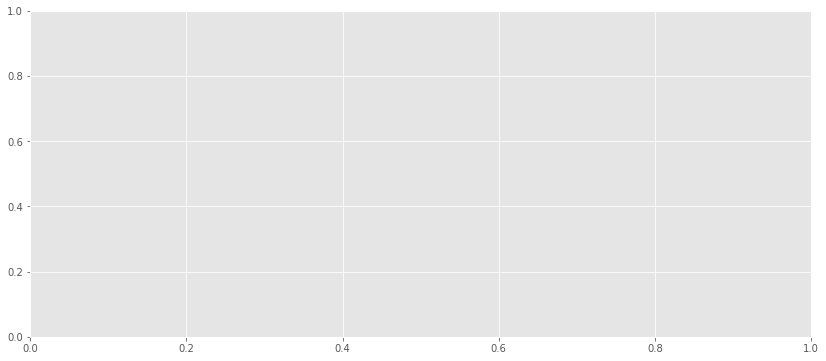

In [9]:
true_y = simulate(true_theta, device=CUDA_DEVICE) # ts, q, S

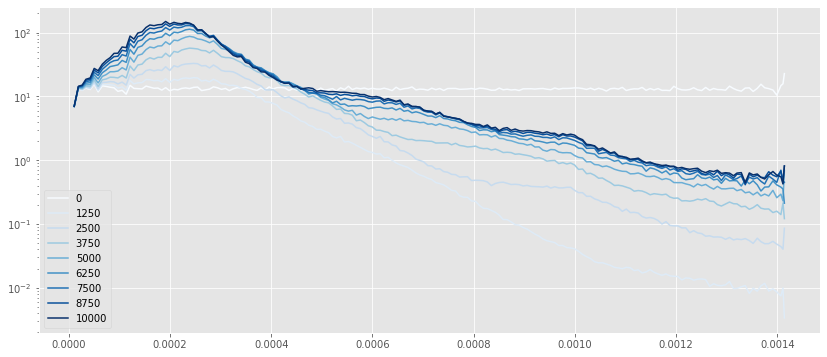

In [18]:
plot_sample(*true_y)

In [20]:
def sqdiff(y,y_):
    ''' (y-y')**2 '''
    return ((y - y_)**2).view(-1)
def mse(*args):
    return sqdiff(*args).mean()
def rmse(*args):
    return tp.sqrt(mse(*args))
def sse(*args):
    return sqdiff(*args).sum()

def loss(true_y, sim_y, metric=mse):
    return metric(true_y[2], sim_y[2])

In [21]:
GRID_RESOLUTION = 5 # **3 = NUM. OPS [keep low] 

In [26]:
grid = tp.linspace(0.01, 0.99, GRID_RESOLUTION)

#a, b, k = true_theta['a'], true_theta['b'], true_theta['k']

losses = []

for ia, gi in enumerate(grid):
    a = theta_priors['a'].icdf(gi)
    for ib, gj in enumerate(grid):
        b = theta_priors['b'].icdf(gj)
        for ik, gk in enumerate(grid):
            k = theta_priors['k'].icdf(gk)
            test_theta = {'a':a, 'b':b, 'k':k}
            sample = simulate(test_theta, device=GLOBAL_DEVICE)
            losses.append((test_theta, sample, loss(true_y, sample)))
            sys.stdout.write("\r%3d/%d" % (len(losses), GRID_RESOLUTION**3))
            sys.stdout.flush()

125/125

In [39]:
np.array(test_thetas).shape

(125, 3)

In [38]:
test_thetas = [np.array([thetas['a'].cpu().numpy(), thetas['b'].cpu().numpy(), thetas['k'].cpu().numpy()]) for thetas, _, _ in losses]
test_losses = [loss.cpu().numpy() for _, _, loss in losses]

In [40]:
test_thetas = np.reshape(np.array(test_thetas), (GRID_RESOLUTION, GRID_RESOLUTION, GRID_RESOLUTION, 3))
test_losses = np.reshape(np.array(test_losses), (GRID_RESOLUTION, GRID_RESOLUTION, GRID_RESOLUTION))

In [104]:
[*test_thetas[1,:,0,2]]

[0.68848383, 0.68848383, 0.68848383, 0.68848383, 0.68848383]

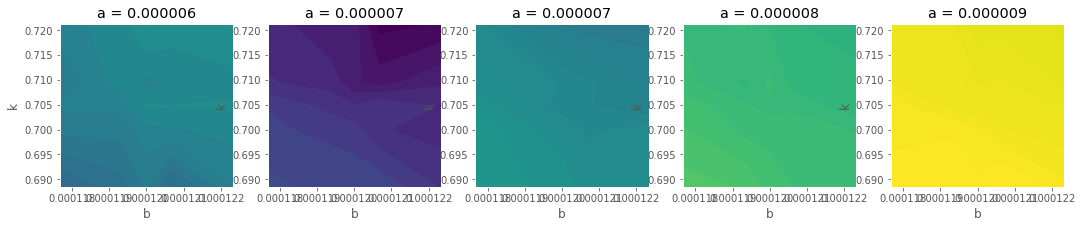

In [108]:
_, axs = plt.subplots(1,5, figsize=(18, 3))

clims = np.min(np.log(test_losses)), np.max(np.log(test_losses))
min_i = np.argmin(test_losses.ravel())
for i in range(5):
    cf = axs[i].contourf([*test_thetas[i,:,0,1]], [*test_thetas[i,0,:,2]], np.log(test_losses[i,:,:]))
    cf.set_clim(*clims)
    axs[i].set_xlabel('b'), axs[i].set_ylabel('k')
   # axs[i].set_clim(*clims)
    axs[i].set_title('a = %f' % test_thetas[i,0,0,0])

In [120]:
opt_theta = losses[min_i][0]
print(opt_theta)
print(true_theta)
[print('|%s-%shat| = %s\n' % (key, key, str(tp.abs(opt_theta[key]-true_theta[key]).cpu().numpy()))) for key in ['a','b','k']]  

{'a': tensor(6.6169e-06), 'b': tensor(0.0001), 'k': tensor(0.7093)}
{'a': tensor(6.2198e-06), 'b': tensor(0.0001), 'k': tensor(0.7057)}
|a-ahat| = 3.9707902e-07

|b-bhat| = 1.9277213e-06

|k-khat| = 0.0036008358



[None, None, None]

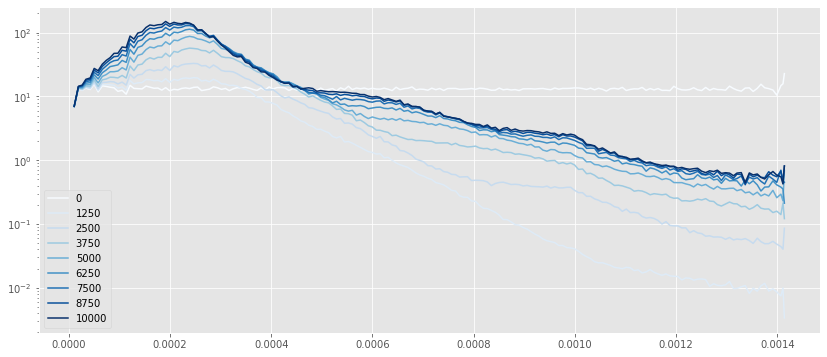

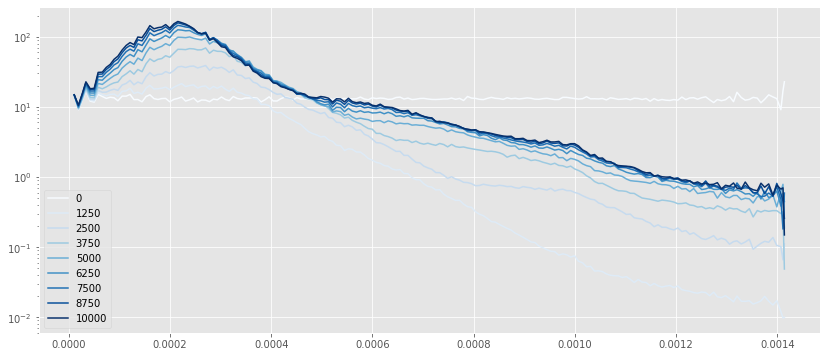

In [121]:
plot_sample(*true_y)
plot_sample(*losses[min_i][1])

### Bayesian optimisation

In [122]:
from GPyOpt.methods import BayesianOptimization

In [137]:
theta_priors = {
    'a': LogNormal(-11.86, 0.1),
    'b': Normal(1.2e-4, 1e-6),
    'k': LogNormal(-0.35, 0.01)
}

def f_of_(X,device=GLOBAL_DEVICE):
    a = theta_priors['a'].icdf(tp.tensor(X[0,0]).to(device))
    b = theta_priors['b'].icdf(tp.tensor(X[0,1]).to(device))
    k = theta_priors['k'].icdf(tp.tensor(X[0,2]).to(device))
    sample = simulate({'a':a, 'b':b, 'k':k}, device=device)
    return loss(true_y, sample).cpu().item()

# train_Y = tp.tensor([f_of_(x) for x in train_X])

In [138]:
domain = [
    {'name': 'a', 'type':'continuous','domain':(0.0001, 0.9999)},
    {'name': 'b', 'type':'continuous','domain':(0.0001, 0.9999)},
    {'name': 'k', 'type':'continuous','domain':(0.0001, 0.9999)}
]

experiment = BayesianOptimization(f = lambda x: f_of_(x), domain=domain)
experiment.run_optimization(max_iter=20)

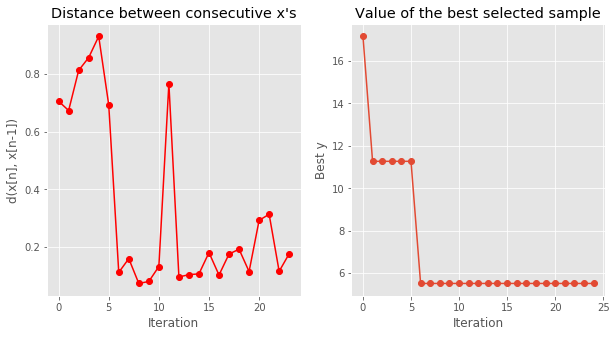

In [139]:
experiment.plot_convergence()

In [157]:
def maptoprior(x, priors=theta_priors):
    keys = ('a','b','k')
    theta = {}
    for i,k in enumerate(keys):
        theta[k] = priors[k].icdf(tp.tensor(x.ravel()[i]))
    return theta

def mapfrompriors(x, priors=theta_priors):
    keys = ('a','b','k')
    theta = {}
    for i,k in enumerate(keys):
        theta[k] = mapfromprior(x.ravel(),priors[k])
    return theta

def mapfromprior(x, prior):
    return prior.cdf(tp.tensor(x))

In [150]:
bayesopt_theta = maptoprior(experiment.x_opt)
print(bayesopt_theta)
print(true_theta)
[print('|%s-%shat| = %s\n' % (key, key, str(tp.abs(bayesopt_theta[key]-true_theta[key]).cpu().numpy()))) for key in ['a','b','k']]  

{'a': tensor(6.2202e-06), 'b': tensor(0.0001), 'k': tensor(0.6997)}
{'a': tensor(6.2198e-06), 'b': tensor(0.0001), 'k': tensor(0.7057)}
|a-ahat| = 3.5015546e-10

|b-bhat| = 1.5892874e-07

|k-khat| = 0.0059986115



[None, None, None]

### Marginals (?)


(25, 3)

In [238]:
def getmesh(xmin,xmax,n=100,pc=0.05):
    offset = pc*(xmax-xmin)
    return np.linspace(xmin-offset,xmax+offset,n)

theta_X = [maptoprior(experiment.X[i,:]) for i in range(25)]
theta_X = np.array([[th['a'],th['b'],th['k']] for th in theta_X])

a_mesh, b_mesh, k_mesh = [getmesh(np.min(theta_X[:,i]),np.max(theta_X[:,i])) for i in range(3)]

In [239]:
experiment.x_opt

array([0.10077767, 0.59471462, 0.2408155 ])

In [243]:
a_opt_mesh = np.repeat([experiment.x_opt[0]],100)
b_opt_mesh = np.repeat([experiment.x_opt[1]],100)
k_opt_mesh = np.repeat([experiment.x_opt[2]],100)

In [265]:
#a_conditional
x_mesh = np.vstack([
    np.array([mapfromprior(x,theta_priors['a']).item() for x in a_mesh]),
    b_opt_mesh,
    k_opt_mesh
])
a_conditional = experiment.model.model.predict(x_mesh.T)

# ab_conditional
x_mesh = np.hstack([np.vstack([
    np.array([mapfromprior(x,theta_priors['a']).item() for x in a_mesh]),
    np.repeat(mapfromprior(b,theta_priors['b']).item(),100),
    k_opt_mesh
]) for b in b_mesh])

ab_conditional = experiment.model.model.predict(x_mesh.T)

# ak_conditional
x_mesh = np.hstack([np.vstack([
    np.array([mapfromprior(x,theta_priors['a']).item() for x in a_mesh]),
    b_opt_mesh,
    np.repeat(mapfromprior(k,theta_priors['k']).item(),100)
]) for k in k_mesh])

ak_conditional = experiment.model.model.predict(x_mesh.T)


# b_conditional
x_mesh = np.vstack([
    a_opt_mesh,
    np.array([mapfromprior(x,theta_priors['b']).item() for x in b_mesh]),
    k_opt_mesh
])
b_conditional = experiment.model.model.predict(x_mesh.T)


# bk_conditional
x_mesh = np.hstack([np.vstack([
    a_opt_mesh,
    np.array([mapfromprior(x,theta_priors['b']).item() for x in b_mesh]),
    np.repeat(mapfromprior(k,theta_priors['k']).item(),100)
]) for k in k_mesh])
bk_conditional = experiment.model.model.predict(x_mesh.T)

# k_conditional
x_mesh = np.vstack([
    a_opt_mesh,
    b_opt_mesh,
    np.array([mapfromprior(x,theta_priors['k']).item() for x in k_mesh])
])
k_conditional = experiment.model.model.predict(x_mesh.T)

In [285]:
testX = [maptoprior(experiment.X[i,:]) for i in range(25)]
testA,testB,testK = [X['a'] for X in testX],[X['b'] for X in testX],[X['k'] for X in testX]

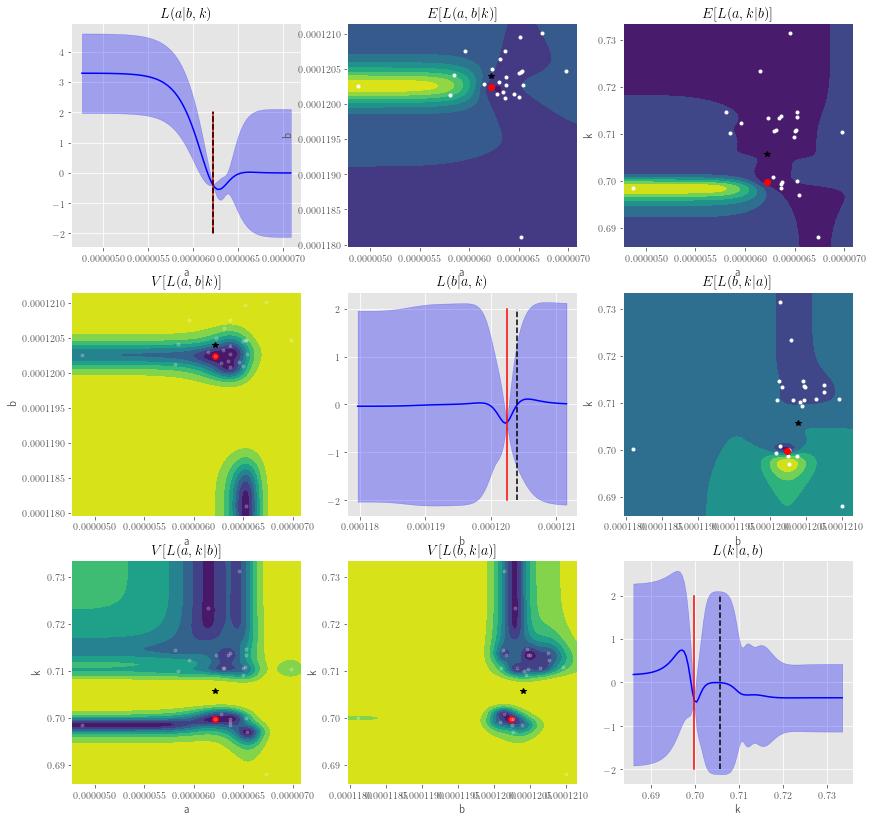

In [295]:
_,axs = plt.subplots(3,3,figsize=(14,14))

dists = [
    [a_conditional, ab_conditional, ak_conditional],
    [ab_conditional, b_conditional, bk_conditional],
    [ak_conditional, bk_conditional, k_conditional]
]
titles = [
    ['$L(a|b,k)$', '$E[L(a,b|k)]$', '$E[L(a,k|b)]$'],
    ['$V[L(a,b|k)]$', '$L(b|a,k)$', '$E[L(b,k|a)]$'],
    ['$V[L(a,k|b)]$', '$V[L(b,k|a)]$', '$L(k|a,b)$'],
]

trues = [
    [true_theta['a'], (true_theta['a'],true_theta['b']), (true_theta['a'],true_theta['k'])],
    [None, true_theta['b'], (true_theta['b'],true_theta['k'])],
    [None, None, true_theta['k']]
]

tests = (testA,testB,testK)

X_opt = experiment.x_opt
X_opt = maptoprior(X_opt)
X_opt = X_opt['a'],X_opt['b'],X_opt['k']

labels = ('a','b','k')

meshes = (a_mesh,b_mesh,k_mesh)

for i in range(3):
    for j in range(3):
        dist = dists[i][j]
        if i == j:
            mu, var = dist
            sd = np.sqrt(var)
            axs[i,j].plot(meshes[i], mu,'b-')
            axs[i,j].fill_between(meshes[i], (mu-1.96*sd).ravel(), (mu+1.96*sd).ravel(), color='b', alpha=0.3)
            axs[i,j].set_xlabel(labels[i])
            axs[i,j].plot([X_opt[i]]*2,[-2,2],'r-')
            axs[i,j].plot([trues[i][j]]*2,[-2,2],'k--')
        elif j > i:
            mu, _ = dist
#             axs[i,j].contourf(np.reshape(mu,(100,100)))
            axs[i,j].contourf(meshes[i],meshes[j],np.reshape(mu,(100,100)))
            axs[i,j].set_xlabel(labels[i])
            axs[i,j].set_ylabel(labels[j])
            axs[i,j].plot(*trues[i][j],'k*')
            axs[i,j].plot(tests[i],tests[j],'w.')
            axs[i,j].plot(X_opt[i],X_opt[j],'ro')
        else:
            _, var = dist
#             axs[i,j].contourf(np.reshape(var,(100,100)))
            axs[i,j].contourf(meshes[j],meshes[i],np.reshape(var,(100,100)))
            axs[i,j].set_xlabel(labels[j])
            axs[i,j].set_ylabel(labels[i])
            axs[i,j].plot(X_opt[j],X_opt[i],'ro')
            axs[i,j].plot(*trues[j][i],'k*')
            axs[i,j].plot(tests[j],tests[i],'w.',alpha=0.2)
        axs[i,j].set_title(titles[i][j])